# World Development Indicators and Life Expectancy in 2010

This notebook examines adult literacy worldwide and what factors lead to having a high life expectancy in the year 2010. The data used in this notebook come from [Kaggle](https://www.kaggle.com/worldbank/world-development-indicators). To start, we load in the relevant libraries and SQLite database using SQLalchemy and print the table and column names.

In [1]:
# import relevant libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sqla

In [26]:
# Connect to SQLite database found in database.sqlite

metadata = sqla.MetaData()

engine =  sqla.create_engine("sqlite:///database.sqlite")

table_names = engine.table_names()

tables = dict()

for table in table_names:
    print("\n"+table+" columns:\n")
    tables[table] = sqla.Table(table, metadata, autoload=True, autoload_with=engine)
    for column in tables[table].c.keys():
        print(column)


Country columns:

CountryCode
ShortName
TableName
LongName
Alpha2Code
CurrencyUnit
SpecialNotes
Region
IncomeGroup
Wb2Code
NationalAccountsBaseYear
NationalAccountsReferenceYear
SnaPriceValuation
LendingCategory
OtherGroups
SystemOfNationalAccounts
AlternativeConversionFactor
PppSurveyYear
BalanceOfPaymentsManualInUse
ExternalDebtReportingStatus
SystemOfTrade
GovernmentAccountingConcept
ImfDataDisseminationStandard
LatestPopulationCensus
LatestHouseholdSurvey
SourceOfMostRecentIncomeAndExpenditureData
VitalRegistrationComplete
LatestAgriculturalCensus
LatestIndustrialData
LatestTradeData
LatestWaterWithdrawalData

CountryNotes columns:

Countrycode
Seriescode
Description

Footnotes columns:

Countrycode
Seriescode
Year
Description

Indicators columns:

CountryName
CountryCode
IndicatorName
IndicatorCode
Year
Value

Series columns:

SeriesCode
Topic
IndicatorName
ShortDefinition
LongDefinition
UnitOfMeasure
Periodicity
BasePeriod
OtherNotes
AggregationMethod
LimitationsAndExceptions
No

## Exploratory Analysis

Once we have created an engine and loaded the tables from the database, we can then do an exploratory analysis of the data. We want to examine life expectancy, but first we must find which indicator in our table refers to this field. We use the Indicators and Series table to find indicators with the word "life expectancy" in them, and print the name of the indicator, the IndicatorCode, and a description of the Indicator.

In [58]:
# Create SQL query 

# Select distinct IndicatorNames (to avoid repeating the same indicator for each country)

stmt = sqla.select([tables["Indicators"].c.IndicatorName.distinct(), 
                    tables["Indicators"].c.IndicatorCode,
                    tables["Series"].c.LongDefinition])

# Use JOIN to find description under series name

stmt = stmt.select_from(
    tables["Indicators"].join(tables["Series"], 
                             tables["Indicators"].c.IndicatorCode == tables["Series"].c.SeriesCode)
)

# Find indicators that have "literacy" somewhere

stmt = stmt.where(tables["Indicators"].c.IndicatorName.ilike("%life expectancy%"))

# Connect to the engine and execute the statement.

conn = engine.connect()

for result in conn.execute(stmt):
    print(result.IndicatorName, result.IndicatorCode)
    print(result.LongDefinition)
    print("\n")

conn.close()

Life expectancy at birth, female (years) SP.DYN.LE00.FE.IN
Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.


Life expectancy at birth, male (years) SP.DYN.LE00.MA.IN
Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.


Life expectancy at birth, total (years) SP.DYN.LE00.IN
Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.




From these queries, we have identified that the indicator that most closely matches our query is the life expectancy at birth, which has the code SP.DYN.LE00.IN. We then use this to select this literacy rate for the year 2010 and plot it on a histogram.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
CountryName       200 non-null object
LifeExpectancy    200 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB
None
       LifeExpectancy
count      200.000000
mean        70.281327
std          8.947131
min         47.483415
25%         64.771524
50%         72.798463
75%         76.722341
max         83.159379


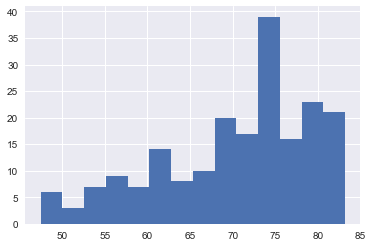

In [65]:
%matplotlib inline
# Create SQL query

stmt = sqla.select([tables["Indicators"].c.CountryName, tables["Indicators"].c.Value.label("LifeExpectancy")])


# Use to avoid selecting regions instead of countries
stmt = stmt.select_from(tables["Indicators"].join(tables["Country"],
                                                 tables["Country"].c.CountryCode == tables["Indicators"].c.CountryCode))

stmt = stmt.where(sqla.and_(tables["Country"].c.Region.isnot(""),
                            tables["Indicators"].c.IndicatorCode == "SP.DYN.LE00.IN",
                            tables["Indicators"].c.Year == 2010)
    )


conn = engine.connect()

# Load into pandas dataframe

life_exp = pd.read_sql_query(stmt, conn)

print(life_exp.info())
print(life_exp.describe())


plt.hist(life_exp["LifeExpectancy"], bins = 14)

conn.close()